##### Order of Operation
1. import
2. read in training data 
3. clean data 
4. stem words with snowball stemmer
5. pipeline tfidf vectorizer, [selected classifier]
6. choose best pipeline
7. gridsearchcv on pipeline to find best tuned classifier
8. test on other data i.e. Kaggle, friends, etc...

## Introduction
In this project, I try to optimize a supervised machine learning algorithm to predict Myers-Briggs personality profiles of Kaggle forum users based on the [(MBTI) Myers-Briggs Personality Type Dataset](https://www.kaggle.com/datasnaek/mbti-type) on Kaggle. 

This notebook was forked from [this](https://www.kaggle.com/lbronchal/what-s-the-personality-of-kaggle-users) Kaggle kernel. 

In [55]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer

In [23]:
train_data = pd.read_csv('../mbti-project/mbti_1.csv')
user_data = pd.read_csv('../mbti-project/Users.csv')
forum_data = pd.read_csv('../mbti-project/ForumMessages.csv')
mbti = {'I':'Introversion', 'E':'Extroversion', 'N':'Intuition', 
        'S':'Sensing', 'T':'Thinking', 'F': 'Feeling', 
        'J':'Judging', 'P': 'Perceiving'}

Let's look at the structure of the dataset.

In [24]:
train_data.shape

(8675, 2)

Let's look at the distribution of personality profile types in the training data.

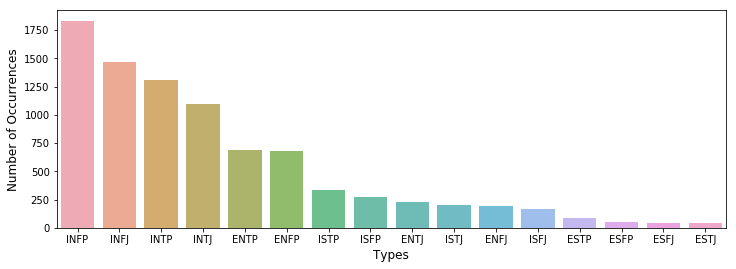

In [25]:
type_count = train_data['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(type_count.index, type_count.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

The personality types seems to be heavily skewed to the right.

Let's see if there are missing values in our data.

In [26]:
print('Forum Missing Values:')
print(forum_data.isnull().sum())
print('\n')
print('User Missing Values:')
print(user_data.isnull().sum())
print('\n')
print('Training Missing Values:')
print(train_data.isnull().sum())

Forum Missing Values:
Id                           0
ForumTopicId                 0
AuthorUserId                 0
PostDate                     0
Message                    581
ReplyToForumMessageId    70620
TopicMessagePosition         0
RawMarkdown              60694
Score                        0
FlaggedCount                 0
dtype: int64


User Missing Values:
Id                     0
UserName          267200
DisplayName           21
RegisterDate           0
Points            510138
Ranking           510138
Tier                   0
HighestRanking    510132
dtype: int64


Training Missing Values:
type     0
posts    0
dtype: int64


Fill missing values for `forum_data['Message']` with blank space.

In [27]:
forum_data['Message'] = forum_data['Message'].fillna('')

print('Forum Missing Values:')
print(forum_data.isnull().sum())

Forum Missing Values:
Id                           0
ForumTopicId                 0
AuthorUserId                 0
PostDate                     0
Message                      0
ReplyToForumMessageId    70620
TopicMessagePosition         0
RawMarkdown              60694
Score                        0
FlaggedCount                 0
dtype: int64


In [28]:
print(forum_data['AuthorUserId'].value_counts())

3258      1459
993       1353
2242      1191
59561     1011
5309       913
114978     699
1828       679
100236     604
6696       510
24266      499
317687     488
75837      451
2505       436
140793     390
368        377
23831      376
3716       375
263583     362
111776     341
147404     323
1335       320
4398       315
37404      310
111640     284
102203     264
381        263
2194       253
10035      239
2036       239
131576     237
          ... 
138735       1
2839         1
201524       1
217916       1
111072       1
405968       1
80305        1
391593       1
231655       1
116975       1
80113        1
170245       1
49422        1
55030        1
10515        1
31001        1
233764       1
366885       1
397037       1
217404       1
145130       1
158043       1
637281       1
51599        1
405904       1
358082       1
155303       1
131478       1
389544       1
14329        1
Name: AuthorUserId, Length: 13340, dtype: int64


Since a given user might have posted more than once on Kaggle forums, I will group all `'Message'` together for each unique user.

In [29]:
forum_data_agg = forum_data.groupby('AuthorUserId')['Message'].agg(lambda col: ' '.join(col)).reset_index()

In [31]:
print(forum_data_agg['AuthorUserId'].value_counts())

71677     1
151016    1
494738    1
2708      1
126473    1
121486    1
19084     1
27272     1
605816    1
33413     1
43648     1
643711    1
518776    1
137846    1
45683     1
47730     1
43632     1
348783    1
62059     1
326250    1
21284     1
27240     1
397927    1
203366    1
33381     1
23198     1
144035    1
129706    1
105158    1
552523    1
         ..
406442    1
277709    1
13516     1
595094    1
449793    1
617783    1
58666     1
320822    1
294197    1
301551    1
118067    1
77103     1
146733    1
13612     1
38022     1
345378    1
87328     1
7108      1
629725    1
40435     1
202008    1
58646     1
51550     1
96258     1
285969    1
61922     1
9486      1
460042    1
138505    1
327680    1
Name: AuthorUserId, Length: 13340, dtype: int64


Clean `train_data['posts']`.

In [88]:
#function to clean data
def clean_text(text):
    #get rid of html and seperators
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r'  ', text) 
    text = re.sub(r'http\S+', r'  ', text)
    #get rid of punctuation
    text = text.replace('.', '  ')
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    #get rid of numbers
    text = ''.join(i for i in text if not i.isdigit())
    return text

In [97]:
train_data['clean_posts'] = train_data['posts'].apply(clean_text)

In [89]:
forum_data_agg['clean_messages'] = forum_data_agg['Message'].apply(clean_text)

In [90]:
print(forum_data_agg['clean_messages'][1])

The public leaderboard is only indicative because competitors can use information on their score to get information on a portion of the test dataset   The final results are a quite different and b better reflect actual performance   Hi Tanya Kaggle will maintain a rating system   If you win but youre ineligible for prize money you will still get a strong rating  Anthony GiovanniThanks for your feedback   Using the forum to give feedback is a good idea   It allows others to see and comment on suggestions   We might set up a proper feedback forum but for the moment this topic will have to suffice   I also agree that the forum is a bit clunky   However we have a large list of feature requests and only limited resources for the moment  it might take us some time to address this   Apologies   I dont think the prize money in this competition is that relevant the prize is relatively small   Correct me if Im wrong but I think contestants are driven by intrinsic factors  A karma system that rew

The messages are almost cleaned except there are certain words that are fused together like 'mindAnthony' and 'CommunityForum'. I will need to split those words apart. 

In [91]:
#function to split string by uppercase
def split_uppercase(text):
    return re.sub(r'([A-Z])', r' \1', text)

In [92]:
forum_data_agg['clean_messages'] = forum_data_agg['clean_messages'].apply(split_uppercase)

In [93]:
print(forum_data_agg['clean_messages'][1])

 The public leaderboard is only indicative because competitors can use information on their score to get information on a portion of the test dataset    The final results are a quite different and b better reflect actual performance    Hi  Tanya  Kaggle will maintain a rating system    If you win but youre ineligible for prize money you will still get a strong rating   Anthony  Giovanni Thanks for your feedback    Using the forum to give feedback is a good idea    It allows others to see and comment on suggestions    We might set up a proper feedback forum but for the moment this topic will have to suffice    I also agree that the forum is a bit clunky    However we have a large list of feature requests and only limited resources for the moment  it might take us some time to address this    Apologies    I dont think the prize money in this competition is that relevant the prize is relatively small    Correct me if  Im wrong but  I think contestants are driven by intrinsic factors   A k

Looks much better now. I'll stem the words next.

In [59]:
#function to stem words
def stem_text(text):
    stemmer = SnowballStemmer('english')
    words_list = text.split()
    new_list = []
    for i in words_list:
        word = stemmer.stem(i)
        new_list.append(word)
        
    words = new_list
    words = ' '.join(words)
    return words

In [60]:
train_data['clean_posts'] = train_data['clean_posts'].apply(stem_text)

In [94]:
forum_data_agg['clean_messages'] = forum_data_agg['clean_messages'].apply(stem_text)

So, I cleaned all the training and forum text data. Now, I'll build my pipeline and test a few different classifiers.